**Next Word Prediction**

In [4]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 25.3 MB/s 


In [5]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
import heapq

np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [7]:
path = '8.txt'
txt = open(path, encoding='utf-8').read().lower()
print('corpus length', len(txt))

corpus length 581888


In [8]:
chars = sorted(list(set(txt)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print ("unique chars: ",len(chars))

unique chars:  73


Feature Engineering :

In [9]:
SEQUENCE_LENGTH = 39
step = 3
sentences = []
next_chars = []
for i in range(0, len(txt) - SEQUENCE_LENGTH, step):
    sentences.append(txt[i:i+SEQUENCE_LENGTH])
    next_chars.append(txt[i+SEQUENCE_LENGTH])
print ('num training examples: ',len(sentences))

num training examples:  193950


In [10]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [11]:
print(X[0][0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True]


Model Building :

In [12]:
model = Sequential();
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


Model Training :

In [13]:
optimizer = RMSprop(lr= 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10
1440/1440 [==============================] - 163s 111ms/step - loss: 1.9733 - accuracy: 0.4198 - val_loss: 2.1252 - val_accuracy: 0.4088
Epoch 2/10
1440/1440 [==============================] - 159s 110ms/step - loss: 1.6143 - accuracy: 0.5169 - val_loss: 2.0645 - val_accuracy: 0.4379
Epoch 3/10
1440/1440 [==============================] - 158s 110ms/step - loss: 1.5141 - accuracy: 0.5447 - val_loss: 2.0444 - val_accuracy: 0.4393
Epoch 4/10
1440/1440 [==============================] - 159s 110ms/step - loss: 1.4613 - accuracy: 0.5589 - val_loss: 2.0503 - val_accuracy: 0.4535
Epoch 5/10
1440/1440 [==============================] - 159s 110ms/step - loss: 1.4265 - accuracy: 0.5673 - val_loss: 2.0349 - val_accuracy: 0.4533
Epoch 6/10
1440/1440 [==============================] - 159s 110ms/step - loss: 1.4005 - accuracy: 0.5746 - val_loss: 2.0477 - val_accuracy: 0.4504
Epoch 7/10
1440/1440 [==============================] - 159s 110ms/step - loss: 1.3813 - accuracy: 0.5787 - val_

In [14]:
model.save('LGMVIP_Task8_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('LGMVIP_Task8_model.h5')
history = pickle.load(open("history.p", "rb"))

Evaluating the Next Word Prediction Model :

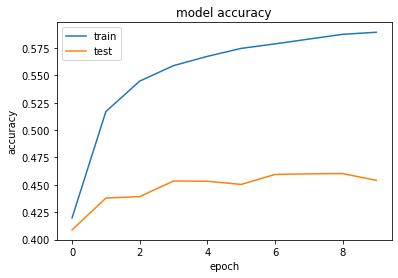

In [15]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig("Task8_Accuracy.png")

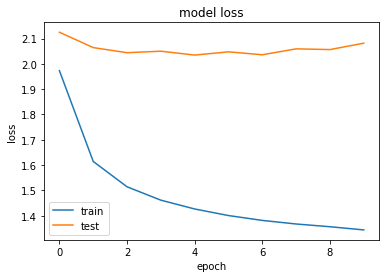

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'best')
plt.savefig("Task8_Loss.png")

In [17]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1
    return x

The Sample function :

In [18]:
def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [19]:
def predict_completion(text):
    original_text = text
    generalised = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
    text = txt[1:] + next_char
    completion += next_char
    if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
                return completion

Prediction of multiple completions :

In [20]:
def predict_completions(text, n = 3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [21]:
# Sample Test case
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
for q in quotes:
    seq = q[:SEQUENCE_LENGTH].lower()
    print (seq)
    print (predict_completions(seq, 5))

it is not a lack of love, but a lack of
